In [ ]:
!pip install geopandas

In [ ]:
!pip install contextily

In [ ]:
!pip install mapclassify

In [ ]:
!pip install pysal

In [ ]:
!pip install splot

In [ ]:
import geopandas, pandas, mapclassify
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed
%matplotlib inline

In [ ]:
def add_basemap(axe,isaxis=False,cx_source=cx.providers.Stamen.TonerLite,crs="EPSG:4326"):
    # remove axis
    if not isaxis:
      axe.set_axis_off()
    # Add toner background
    cx.add_basemap(
      axe, 
      crs=crs,
      source=cx_source
    )
def scatter_plot(db,color,alpha,ax,isaxis=False,
                 cx_source=cx.providers.Stamen.TonerLite,crs="EPSG:4326",size=4,isbound=False,
                 neig=None,vals=["longitude", "latitude",],label=""):
    axe = db.plot.scatter(
      vals[0], 
      vals[1],
      ax=ax,
      s=size,
      c=color,
      alpha=alpha,
      label=label,
      marker="*"
      
    )
    if isbound:
      neig.plot(
      ax=ax,
      facecolor="none",
      edgecolor="xkcd:blue",label="boundaries",legend_kwds={"loc": 4},alpha=0.3)
    add_basemap(ax,isaxis,cx_source,crs)
def quantile_map(db,column,scheme,ax,isaxis=False,cx_source=cx.providers.Stamen.TonerLite,crs="EPSG:4326",isbase=True):
    # Plot the equal interval choropleth and add a legend
    axe=neis.plot(
      column=column, 
      scheme=scheme, 
      ax=ax,
      k=5,
      legend=True,
       cmap="plasma",
      legend_kwds={"loc": 4},

    )
    if isbase:
      add_basemap(ax,isaxis,cx_source,crs)
def kde_plot(db,n_levels,alpha,ax,isaxis=False,cx_source=cx.providers.Stamen.TonerLite,crs="EPSG:4326",isbound=False,neig=None):
    
    # Add KDE layer that displays probability surface
    axe=sns.kdeplot(
      db["longitude"], 
      db["latitude"], 
      n_levels=n_levels, 
     
      alpha=alpha,
      cmap="plasma",
      legend=True
    )
    add_basemap(ax,isaxis,cx_source,crs)
    # Add title of the map
def standardize(dataSeries):
  return (dataSeries-dataSeries.mean())/dataSeries.std()

<p>
deg_bachelor and employed are the two variables considered for this analysis, the reason to picking these variables is for the study of the rate of employability for employees with at least a bachelor's degree. The above two variables are picked from the socioeconomic dataset.
</p>


---



In [83]:
neis = geopandas.read_file("https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg")
neis['deg_bachelor_std']=standardize(neis['deg_bachelor'])
neis['employed_std']=standardize(neis['employed'])
weight = weights.Queen.from_dataframe(neis, idVariable="AREA_NAME")
neis['w_deg_bachelor'] = weights.lag_spatial(weight, neis['deg_bachelor_std'])
neis['w_employed'] = weights.lag_spatial(weight, neis['employed_std'])

 Moran I of employed is 0.0861572592320537 
 Moran I of deg_bachelor is 0.10974370358331197


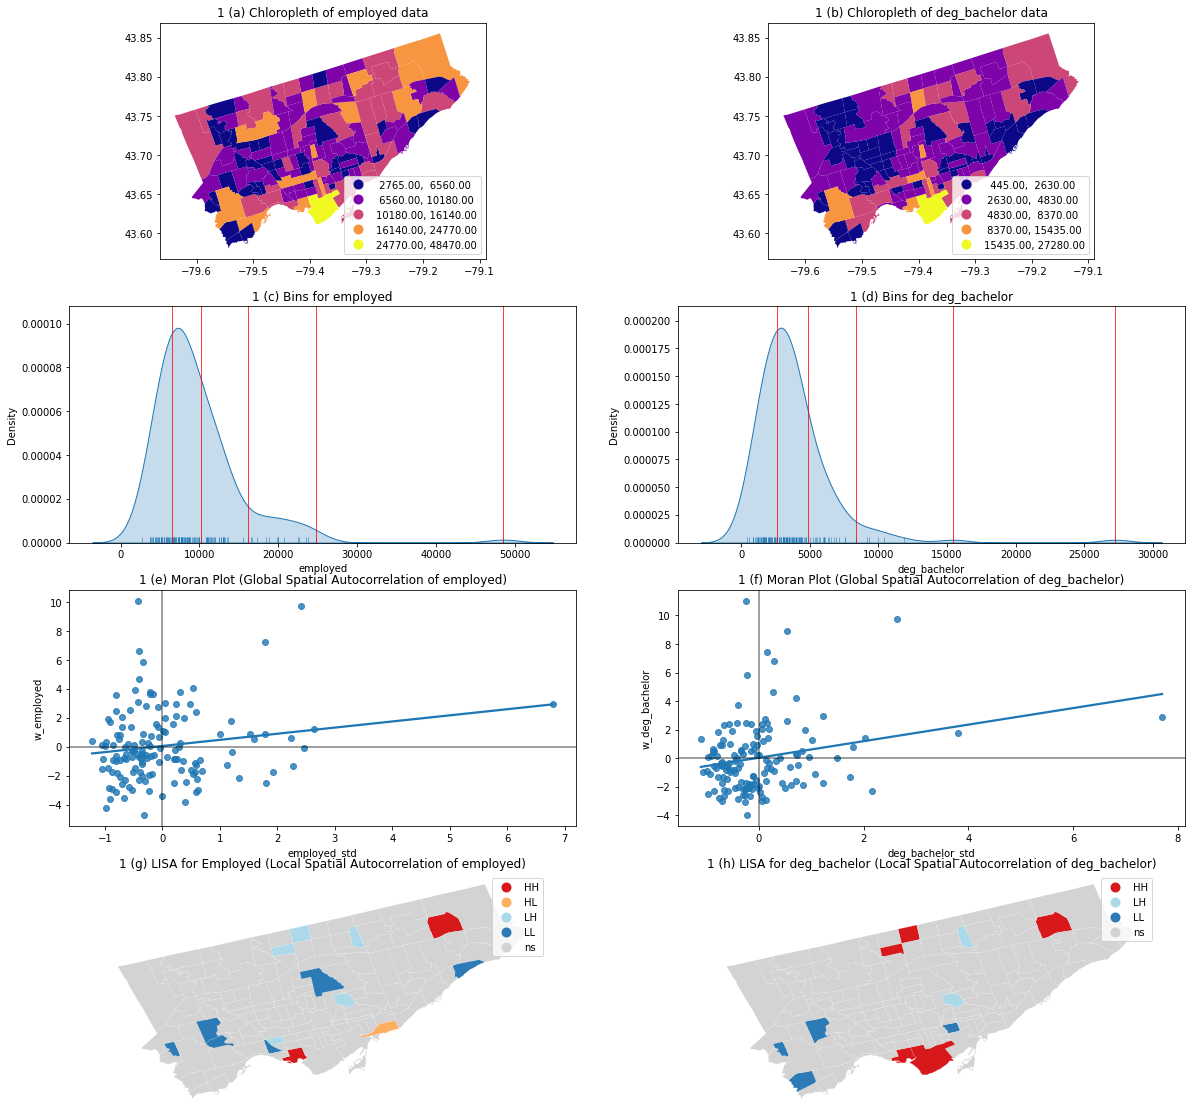

In [84]:
f, ax = plt.subplots(4,2, figsize=(20,20))
ax[0][0].set_title("1 (a) Chloropleth of employed data")
quantile_map(neis,column="employed", scheme="fisher_jenks",ax=ax[0][0],isaxis=True,isbase=False)
ax[0][1].set_title("1 (b) Chloropleth of deg_bachelor data")
quantile_map(neis,column="deg_bachelor", scheme="fisher_jenks",ax=ax[0][1],isaxis=True,isbase=False)
classi_emplo = mapclassify.FisherJenks(neis["employed"], k=5)
classi_deg_bach = mapclassify.FisherJenks(neis["deg_bachelor"], k=5)

ax[1][0].set_title("1 (c) Bins for employed")
sns.kdeplot(ax=ax[1][0],x=neis["employed"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(ax=ax[1][0],x=neis["employed"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_emplo.bins:
    ax[1][0].axvline(cut, color='red', linewidth=0.75)
# Display image

ax[1][1].set_title("1 (d) Bins for deg_bachelor")
# Plot the kernel density estimation (KDE)
sns.kdeplot(ax=ax[1][1],x=neis["deg_bachelor"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(ax=ax[1][1],x=neis["deg_bachelor"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_deg_bach.bins:
    ax[1][1].axvline(cut, color='red', linewidth=0.75)
# Display image
sns.regplot(ax=ax[2][1],x='deg_bachelor_std', y='w_deg_bachelor', data=neis, ci=None)
# Add vertical and horizontal lines
ax[2][1].axvline(0, c='k', alpha=0.5)
ax[2][1].axhline(0, c='k', alpha=0.5)

ax[2][1].set_title("1 (f) Moran Plot (Global Spatial Autocorrelation of deg_bachelor)")
moran_emp = esda.Moran(neis['employed_std'], weight)
moran_deg = esda.Moran(neis['deg_bachelor_std'], weight)

print(f" Moran I of employed is {moran_emp.I} \n Moran I of deg_bachelor is {moran_deg.I}")
# Setup the figure and axis
# Plot values
sns.regplot(ax=ax[2][0],x='employed_std', y='w_employed', data=neis, ci=None)
# Add vertical and horizontal lines
ax[2][0].axvline(0, c='k', alpha=0.5)
ax[2][0].axhline(0, c='k', alpha=0.5)

ax[2][0].set_title("1 (e) Moran Plot (Global Spatial Autocorrelation of employed)")
# Display

lisa_emp = esda.Moran_Local(neis['employed_std'], weight)
lisa_deg = esda.Moran_Local(neis['deg_bachelor_std'], weight)

neis['significant'] = lisa_emp.p_sim < 0.05
# Store the quadrant they belong to
neis['quadrant'] = lisa_emp.q
# plot_local_autocorrelation(lisa_emp, neis, 'employed_std');
lisa_cluster(lisa_emp,neis,ax=ax[3][0])

neis['significant'] = lisa_deg.p_sim < 0.05
# Store the quadrant they belong to
neis['quadrant'] = lisa_deg.q
# plot_local_autocorrelation(lisa_deg, neis, 'deg_bachelor_std');
lisa_cluster(lisa_deg,neis,ax=ax[3][1])
ax[3][0].set_title("1 (g) LISA for Employed (Local Spatial Autocorrelation of employed)")
ax[3][1].set_title("1 (h) LISA for deg_bachelor (Local Spatial Autocorrelation of deg_bachelor)")
plt.show()
# Display



<p>
From figures 1. a and 1. b, the visual interpretation of the spatial distribution of employed data and deg_bachelor data are presented with the help of the Fisher Jenks method. From the color scheme intensity, the discretization of the geographic distribution can be understood. The Yellow color represents the maximal value ( wider bin of values with minimum span) and blue represents the lowest value of classification with the maximum span, which can be visualized in the bin diagram (Kernel Density estimation diagram with lines representing the bin segment) 1. c and 1.d, the largest and smallest bin being between 24771 to 48470 and 2765 to 6560 in the employed data, whereas 15435 to 27280 and 445 to 2630 in the deg_bachelor data.


</p>


---



The degree of how these subjects (employed and bachelor degree holders) in an area are similar to their neighbors (degree of clustering) are visually represented in the Moran plots 1 (e) and 1 (f), from the moran plot of the standardized version of these values and their associated spatial lags appear to be positively correlated as both the curves are increasing towards the positive quadrant, with this we can interpret that the similar values are closer to each other. Furthermore, this analysis can be understood from Moran's I value (slope of the curves), which is nearly 0.08 for employed and 0.1 for deg_bachelors.

Coming to the LISA (Local Indicators of Spatial Association) from figures 1 (g) and 1(h). From the LISA of Employed data, the Red portion of the map indicates the high number of Employed people neighborhoods, whereas the dark blue region indicates the low number of employed people neighborhoods. Also, a few outliers with a low number of employed people surrounded by a High number can be seen with a light sky blue color. Similarly, with the same color pattern, the highest bachelor degree holding neighborhood can be seen in the red portions, whereas the neighborhood of the low number is in dark blue color, Interestingly, two different outliers can be spotted in the maps, where Low numbers surround a high number of holders in orange colored portions and a low number of holders surrounded by high numbers can be seen in sky blue.


---



In [85]:
photos = pandas.read_csv("https://darribas.org/gds_course/_downloads/fc771c3b1b9e0ee00e875bb2d293adcd/toronto_flickr_subset.csv")
photos_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            photos["longitude"], photos["latitude"]
        )
    }, crs="EPSG:4326"
).join(photos)
crosswalk = gpd.sjoin(photos_gdf, neis, how="inner")
photos["admin_area"] = crosswalk["_id"]
photos_by_area = photos.groupby("admin_area").size()
# Assign counts into a table of its own 
# and joins it to the areas table
neis = neis.join(
    pd.DataFrame({"photo_count": photos_by_area}),
    on="_id"
)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


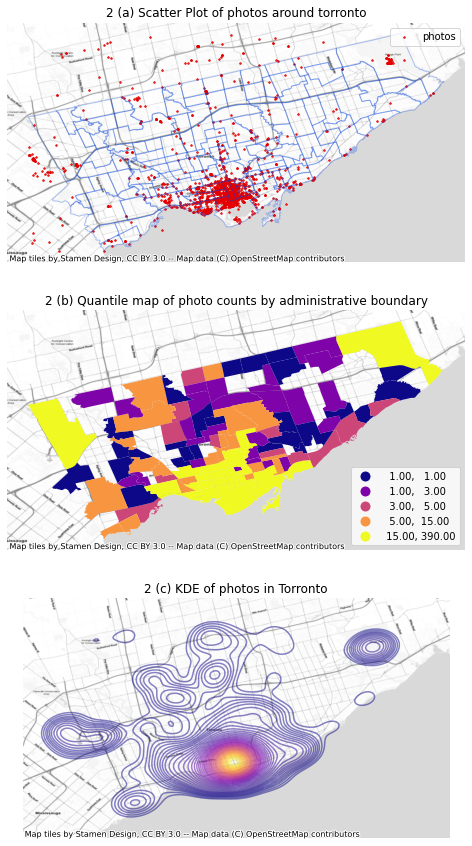

In [86]:
f, ax = plt.subplots(3,figsize=(15,15))
ax[0].set_title("2 (a) Scatter Plot of photos around torronto")

scatter_plot(photos,"xkcd:red",0.7,ax[0],isbound=True,neig=neis,label="photos")
ax[1].set_title("2 (b) Quantile map of photo counts by administrative boundary")

quantile_map(neis,'photo_count','quantiles',ax[1])
ax[2].set_title("2 (c) KDE of photos in Torronto")
kde_plot(photos,50,0.5,ax[2])



The dataset has been visualized with the help of a scatterplot along with the administrative area, A Chloropleth representing the number of photos in the areas, and a Kernel Density Estimation plot from the figures 2 (a), 2 (b) and 2(c). The scatterplot in figure 2 (a), represents a major number of photos that have been taken in the central lower regions of Toronto, for a much clearer idea, the quantile map in figure 2(b) can be referred to, The bright yellow regions represent the highest number of photos taken from 15 to 390. whereas the lowest blue and violet with a wider bin of values from 1 to 3. Furthermore, a vague understanding of continuous distribution can be understood from the KDE Plot.

As these photographs have various reasons, categories, and moments, the data associated with them can be used in multiple ways and for multiple purposes, clustering these all together can help for various reasons, for example, these clusters can be used to address any civil issues, advancements in the society, town planning, tourism, etc. As there is a wide scope of creativity in this topic




---



In [88]:
area=gpd.read_file("/content/drive/MyDrive/University of Liverpool/GDS/Park and Recreation Facility Projects.geojson")

washrooms=gpd.read_file("/content/drive/MyDrive/University of Liverpool/GDS/Public washroom data.geojson")

neighbourhood = gpd.read_file("/content/drive/MyDrive/University of Liverpool/GDS/Neighbourhood Improvement Areas.geojson")

business = gpd.read_file("/content/drive/MyDrive/University of Liverpool/GDS/Business Improvement Areas Data.geojson")

pts = gpd.points_from_xy(
    photos["longitude"],
    photos["latitude"],
    crs="EPSG:4326"
)
# Convert lon/lat points to CRS Torronto in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=7991)
# Extract coordinates from point objects into columns
photos["X_metres"] = pts.geometry.x
photos["Y_metres"] = pts.geometry.y

In [89]:
algo = DBSCAN(eps=2000, min_samples=15)
algo.fit(photos[["X_metres", "Y_metres"]])

lbls = pd.Series(algo.labels_, index=photos.index)
pts_area = gpd.GeoDataFrame(area["geometry"]).to_crs(epsg=7991)
# Extract coordinates from point objects into columns
area["X_metres"] = pts_area.geometry.x
area["Y_metres"] = pts_area.geometry.y



pts_washrooms = gpd.GeoDataFrame(washrooms["geometry"]).to_crs(epsg=7991)
# Extract coordinates from point objects into columns
washrooms["X_metres"] = pts_washrooms.geometry.x
washrooms["Y_metres"] = pts_washrooms.geometry.y

pts_neighborhood = gpd.GeoDataFrame(neighbourhood["geometry"]).to_crs(epsg=7991)
pts_business = gpd.GeoDataFrame(business["geometry"]).to_crs(epsg=7991)


neig = gpd.GeoDataFrame(neis["geometry"]).to_crs(epsg=7991)

Estimated number of clusters: 6
Estimated number of noise points: 158


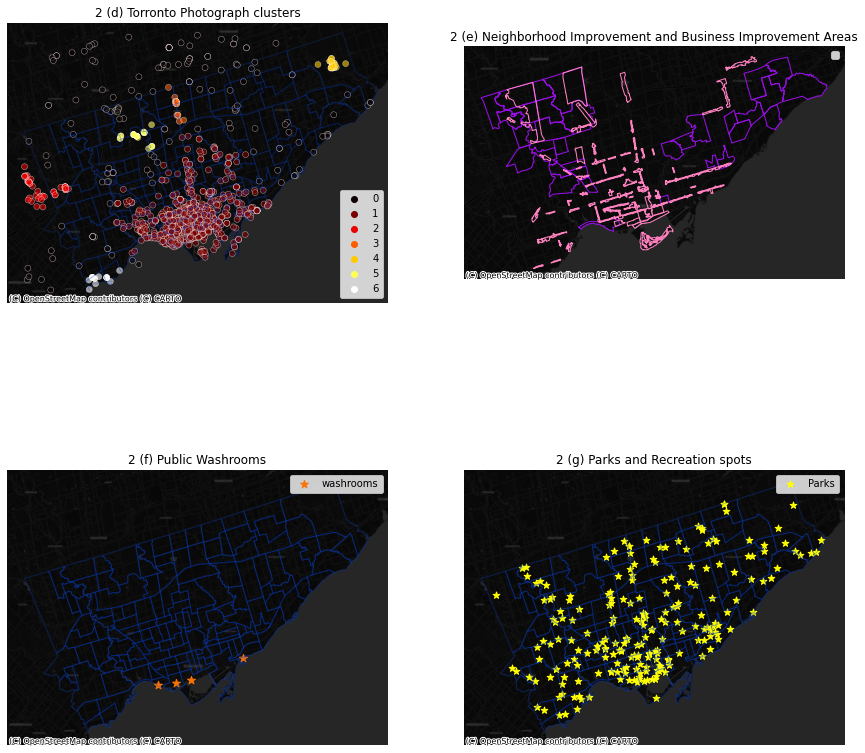

In [90]:
# Setup figure and axis
f, ax = plt.subplots(2,2, figsize=(15,15))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)


n_clusters_ = len(set(algo.labels_)) - (1 if -1 in algo.labels_ else 0)
n_noise_ = list(algo.labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
x=[round(i)+1 if i!=-1 else 0 for i in algo.labels_]


sns.scatterplot(ax=ax[0][0],x=photos.loc[:, "X_metres"],
                
    y=photos.loc[:, "Y_metres"], hue=x, legend="full", palette="hot",alpha=0.6)
add_basemap(ax[0][0],crs="EPSG:7991",cx_source=cx.providers.CartoDB.DarkMatter)


ax[0][0].set_title("2 (d) Torronto Photograph clusters")
ax[0][0].legend(loc="lower right")
neig.plot(ax=ax[0][0],
      facecolor="none",
      edgecolor="xkcd:blue",label="boundaries",alpha=0.2)

ax[0][1].set_title("2 (e) Neighborhood Improvement and Business Improvement Areas")

pts_neighborhood.plot(ax=ax[0][1],
      facecolor="none",
      edgecolor="xkcd:violet",label="boundaries neighbor")


pts_business.plot(ax=ax[0][1],
      facecolor="none",
      edgecolor="xkcd:pink",label="boundaries improvement")
ax[0][1].legend(("boundaries neighbor",'boundaries improvement'))

add_basemap(ax[0][1],crs="EPSG:7991",cx_source=cx.providers.CartoDB.DarkMatter)

scatter_plot(washrooms,'xkcd:orange',1,ax[1][0],vals=["X_metres","Y_metres"],crs="EPSG:7991",size=70,label="washrooms",cx_source=cx.providers.CartoDB.DarkMatter,isbound=True,neig=neig)
ax[1][0].set_title("2 (f) Public Washrooms")
ax[1][1].set_title("2 (g) Parks and Recreation spots")
scatter_plot(area,'yellow',1,ax[1][1],vals=["X_metres","Y_metres"],crs="EPSG:7991",size=50,label="Parks",cx_source=cx.providers.CartoDB.DarkMatter,isbound=True,neig=neig)




<p>
DBScan Clustering algorithm has been performed and visualized in figure 2 (d), here as the calculations for the DBScan are in the local x and y meters (ESPG:7991) for Toronto, all the other maps and data have been converted to the following CRS system. For the DBScan calculation, 15 cores or photograph minimum samples have been considered with a minimum distance or epsilon value of 2000. With this calculation, 6 clusters are drawn with the cores and 158 noise points are identified.

</p>


---


<p>
From figure 2 (d), 6 clusters have been identified ranging from 1 to 6 and a set of noise or outliers in calculation has been visualized with 0 and dark black in the legend. These Clusters are very similar to the quantile maps in 2 (b) with the highest concentration intensity areas being similar. These 6 regions can be called areas of Interest as the highest number of close-range images are taken within those. Here Dark red areas in the lower central region (the main part of Toronto) have the highest concentration of images taken within those areas, followed by magenta (2) (light red) on the left side, dark orange(3) and yellow (5) are neighboring each other along with dark red (1), light orange(4) on the central right corner and white(6) in the bottom left. Figure's legend can be taken as the order of intensity in each of these clusters is arranged as well are directly relating the most significant to the least significant areas of Interest.

</p>


---


<p>
From the Tourism and City welfare perspective, four datasets have been gathered representing Neighborhood Improvement Areas, Business Improvement Areas, Washrooms, and Public park & recreation centers. The data in the above datasets are visualized in figures 2(e), 2(f), and 2(g). From Figure 2 (e). The Neighborhood Improvement Areas and Business Improvement Areas are visualized in Violet and Pink Colors respectively, These regions can be used to understand the overall Improvement of the city. When compared with the areas of interest, it can be interpreted that most of the areas in business improvement zones are containing a maximum number of parts in the areas of Interest, i.e, Cluster 1,3,5, and 6 are mostly in the Business improvement areas. Further improvements can be made in these areas such as the use of advertisements, which improves the business's reachability as these are highly photographed areas on the map. Neighborhood Improvement areas as the name suggests, have 1 to no areas of interest in them. Building recreation centers or carrying out programs can be done in these areas to route them toward improvement and welfare. Tourism development can be understood From Figures 2 (g) and 2(h), Most of the parks and recreation areas can be seen to be photographed as they match with most of the clusters as well as the noise points, but few needs have to be met to improve their overall development, one such use case would be increasing the number of washrooms, from the figure 2 (h), it can be seen that in the 1st cluster (dark red ) or area of Interest, all of the public washrooms are located, this is a very big inconvenience to the tourists who visit these recreation places, The number should be increased concerning the areas of Interest and their intensities, for example, Cluster 2 (Magenta) part can have few public washrooms, Cluster 3 can have washrooms equal to or less than the ones in Cluster 2 and follow by clusters 4,5,6.
</p>


---


